In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import requests
import time
import importlib.util


In [22]:
def load_strategy(path='strategy.py'):
    spec = importlib.util.spec_from_file_location("strategy", path)
    strategy = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(strategy)
    return strategy


strategy = load_strategy()


In [10]:
BINANCE_API_URL = "https://api.binance.com/api/v3/klines"
start_time_ms = 1735689600000  # Jan 1, 2025
end_time_ms = 1747521600000  # May 25, 2025


def fetch_ohlcv(symbol, interval, start_time_ms=start_time_ms, end_time_ms=end_time_ms):
    all_candles = []
    limit = 1000
    current_time = start_time_ms
    try:
        while current_time < end_time_ms:
            params = {
                "symbol": symbol.upper() + "USDT",
                "interval": interval,
                "startTime": current_time,
                "endTime": end_time_ms,
                "limit": limit
            }
            response = requests.get(BINANCE_API_URL, params=params)
            response.raise_for_status()
            data = response.json()
            if not data:
                break
            all_candles.extend(data)
            current_time = data[-1][0] + 1
            time.sleep(0.2)
    except Exception as e:
        raise RuntimeError(f"Failed to fetch data for {symbol}: {e}")

    if not all_candles:
        raise ValueError(f"No data fetched for {symbol}")

    df = pd.DataFrame(all_candles, columns=[
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_volume", "num_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    df = df[["timestamp", "open", "high", "low", "close", "volume"]]
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)
    return df


# Fetch data for LDO, BTC, and ETH
symbols = {"LDO": ("LDO", "1h"), "BTC": ("BTC", "1h"), "ETH": ("ETH", "1h")}
data = {}
for name, (symbol, tf) in symbols.items():
    print(f"Fetching {symbol} ({tf})...")
    data[name] = fetch_ohlcv(symbol, tf)

# Validate data length
for name, df in data.items():
    if len(df) < 100:
        raise ValueError(f"Insufficient data for {name}: only {len(df)} rows fetched")

# Prepare candles_target and candles_anchor
candles_target = data["LDO"].copy()
candles_anchor = data["BTC"][["timestamp", "open", "high", "low", "close", "volume"]].copy()
candles_anchor.columns = ["timestamp"] + [f"{col}_BTC" for col in ["open", "high", "low", "close", "volume"]]
candles_anchor = candles_anchor.merge(
    data["ETH"][["timestamp", "open", "high", "low", "close", "volume"]],
    on="timestamp",
    how="inner"
)
candles_anchor.columns = ["timestamp"] + [f"{col}_BTC" for col in ["open", "high", "low", "close", "volume"]] + \
                         [f"{col}_ETH" for col in ["open", "high", "low", "close", "volume"]]

if len(candles_anchor) < 100:
    raise ValueError(f"Insufficient merged data: only {len(candles_anchor)} rows after merging")


Fetching LDO (1h)...
Fetching BTC (1h)...
Fetching ETH (1h)...


In [23]:
signals_df = strategy.generate_signals(candles_target, candles_anchor)
print("Generated signals (first 5 rows):")
print(signals_df.head())


Generated signals (first 5 rows):
            timestamp signal
0 2025-01-01 00:00:00   HOLD
1 2025-01-01 01:00:00   HOLD
2 2025-01-01 02:00:00   HOLD
3 2025-01-01 03:00:00   HOLD
4 2025-01-01 04:00:00   HOLD


In [24]:
initial_cash = 1000.0
cash = initial_cash
ldo_holding = 0.0
portfolio_values = []
position_size_ratio = 0.5  # Use 50% of available cash per trade

for i in range(len(signals_df)):
    timestamp = signals_df['timestamp'].iloc[i]
    signal = signals_df['signal'].iloc[i]

    # Find the corresponding close price
    matching_rows = candles_target[candles_target['timestamp'] == timestamp]
    if matching_rows.empty:
        print(f"Warning: No close price found for timestamp {timestamp}. Skipping.")
        portfolio_values.append(
            cash + (ldo_holding * (portfolio_values[-1] - cash) / ldo_holding if ldo_holding > 0 else 0))
        continue
    close_price = matching_rows['close'].iloc[0]

    # Spot trading logic: Only buy if no position, sell entire position if holding
    if signal == 'BUY' and ldo_holding == 0 and cash > 0:
        trade_amount = cash * position_size_ratio
        ldo_holding = trade_amount / close_price
        cash -= trade_amount
    elif signal == 'SELL' and ldo_holding > 0:
        cash += ldo_holding * close_price
        ldo_holding = 0.0

    # Calculate portfolio value at this timestamp
    portfolio_value = cash + (ldo_holding * close_price)
    portfolio_values.append(portfolio_value)
signals_df['portfolio_value'] = portfolio_values


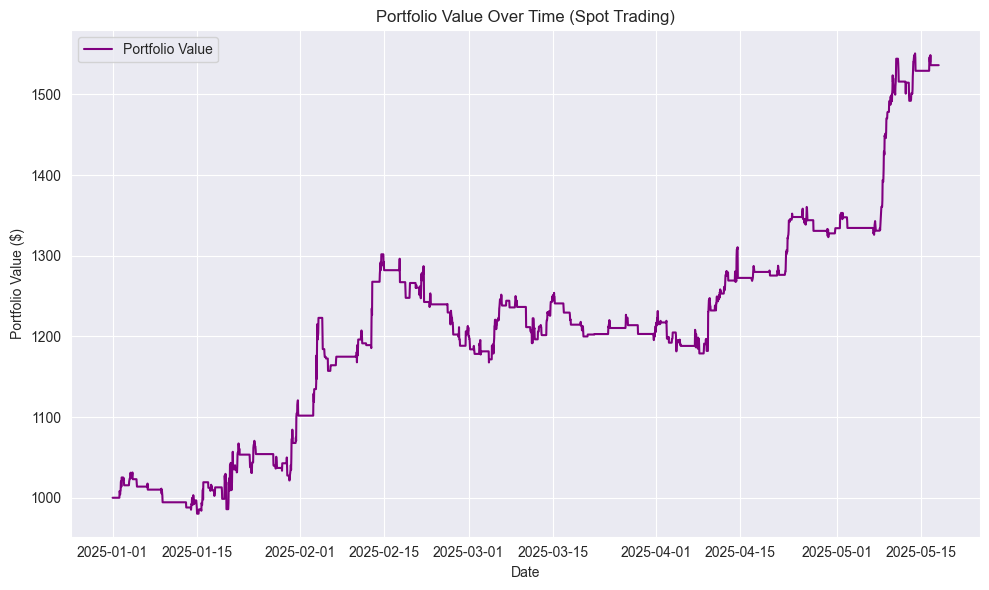

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(signals_df['timestamp'], signals_df['portfolio_value'], label='Portfolio Value', color='purple')
ax.set_title('Portfolio Value Over Time (Spot Trading)')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value ($)')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()


In [26]:
final_portfolio_value = signals_df['portfolio_value'].iloc[-1]
profitability = (final_portfolio_value - initial_cash) / initial_cash * 100
returns = signals_df['portfolio_value'].pct_change().dropna()
sharpe_ratio = (returns.mean() * np.sqrt(24 * 252)) / returns.std() if returns.std() != 0 else np.nan
running_max = signals_df['portfolio_value'].cummax()
drawdowns = (running_max - signals_df['portfolio_value']) / running_max
max_drawdown = drawdowns.max() * 100 if not drawdowns.empty else 0
print(f"\nPerformance Metrics:")
print(f"Profitability: {profitability:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")


Performance Metrics:
Profitability: 53.61%
Sharpe Ratio: 3.03
Max Drawdown: 10.30%
